In [1]:
import numpy as np
import pandas as pd
from scipy.stats import t
from scipy.stats import norm

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split  
from sklearn.datasets import load_diabetes

import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set('notebook', font_scale=1.7, palette='Set2')
%matplotlib inline

# Регуляризация

Регуляризация представляет из себя метод борьбы с переобучением, который заключается в добавлении некоторых ограничений в решаемой задаче оптимизации. Эти ограничения имеют самый разный характер, но все призваны помочь модели выявить истинную (целевую) зависимость и не подстроиться под шум, который присутствует в данных.

Сначала рассмотрим простой пример, демонстрирующий явление переобучения. 

## 1. Переобучение

Определим многочлен третьей степени, который хотим приблизить по 10 точкам на отрезке $[-1, 1]$

In [2]:
def f(x):
    return 3 * (x ** 3) - 2 * (x ** 2) + x

Создадим сетку из 100 точек, которые затем будем использовать в качестве тестовой выборки:

In [3]:
grid = np.linspace(-1, 1, 100)

Изобразим график целевой функции

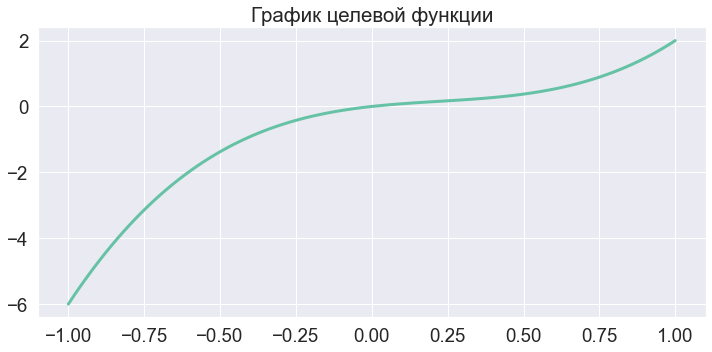

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(grid, f(grid), linewidth=3)
plt.title("График целевой функции")
plt.tight_layout()

plt.show()

Определим обучающую выборку: создадим сетку из 10 точек на отрезке $[-1, 1]$

In [5]:
x = np.linspace(-1, 1, 10)  # 10 точек на отрезке [-1, 1]
y = f(x)

Определим функцию для визуализации экспериментов:

In [6]:
def plot_poly(x, y, grid, f, poly, graph_title):
    """Функция визуализации приближения многочленом
    
    :param x: обучающая выборка (регрессоры),
    :param y: отклики,
    :param grid: тестовая выборка,
    :param f: целевая функция,
    :param poly: функция-многочлен
    :param graph_title: заголовок для графика
    """
    
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, label='Обучающая выборка')
    plt.plot(grid, f(grid), label='Целевая функция', linewidth=3)
    plt.plot(grid, poly(grid), label='Аппроксимация', linewidth=3)
    plt.title(graph_title)
    plt.legend()
    plt.tight_layout()

    plt.show()

Обучим коэффициенты многочлена, приближающего целевую функцию

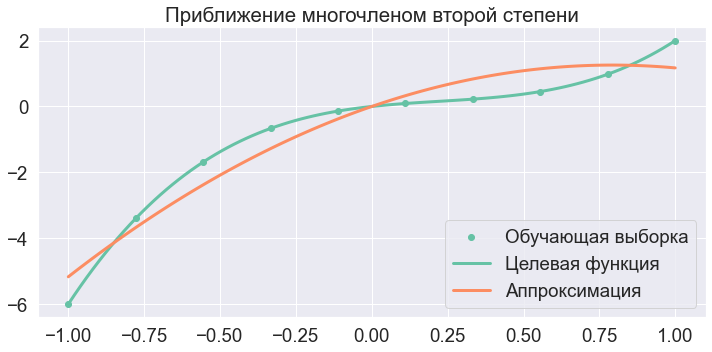

In [7]:
coefs = np.polyfit(x, y, deg=2) # подберем коэффициенты многочлена
poly = np.poly1d(coefs) # объявим функцию-многочлен с полученными коэффициентами

# визуализируем приближение
plot_poly(x, y, grid, f, poly, "Приближение многочленом второй степени")

Видим, что не угадали с моделью (сложно приблизить многочлен третьей степени многочленом второй)

Попробуем теперь использовать многочлен третьей степени в качестве модели

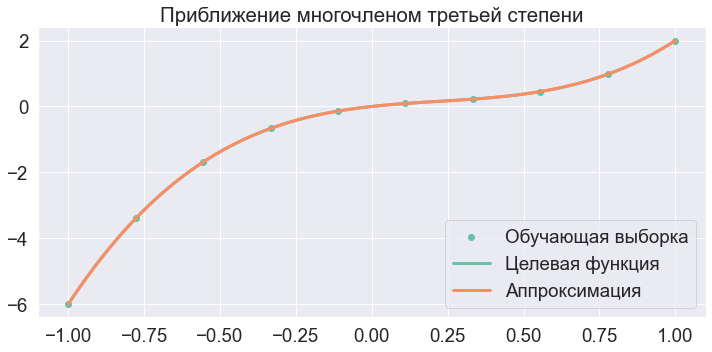

In [8]:
coefs = np.polyfit(x, y, deg=3) # подберем коэффициенты многочлена
poly = np.poly1d(coefs) # объявим функцию-многочлен с полученными коэффициентами

# визуализируем приближение
plot_poly(x, y, grid, f, poly, "Приближение многочленом третьей степени")

Получилась идеальная аппроксимация, чего мы бы и хотели от своей модели

На практике мы редко получаем идеальные данные, которые полностью отражают искомую зависимость (да и искомые функции чаще всего гораздо сложнее, чем просто полином).

Попробуем добавить в данные случайный шум:

In [9]:
def f_real(x):
    return 3 * (x ** 3) - 2 * (x ** 2) + x + np.random.normal(0, 1, x.shape)

И определим новую обучающую выборку:

In [10]:
x = np.linspace(-1, 1, 10)
y = f_real(x) # + np.random.normal(0, 1, 10)  # случайный шум

Теперь попробуем приблизить наши данные многочленом высокой степени:

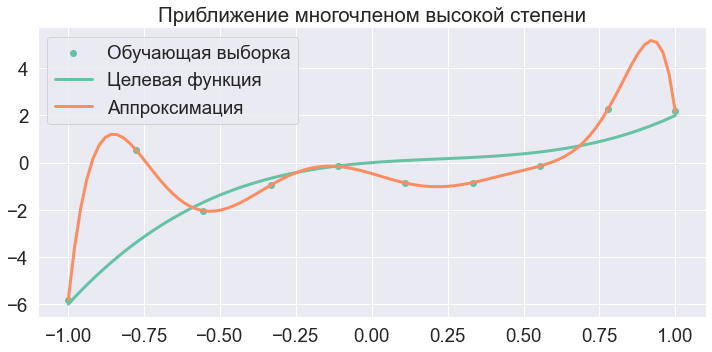

In [11]:
coefs = np.polyfit(x, y, deg=10) # подберем коэффициенты многочлена
poly = np.poly1d(coefs) # объявим функцию-многочлен с полученными коэффициентами

# визуализируем приближение
plot_poly(x, y, grid, f, poly, "Приближение многочленом высокой степени")

Именно так и выглядит переобучение: мы построили слишком сложную модель для имеющихся данных и восстановили зависмость из тренировочной выборки, но не искомую.

Попробуем построить более адекватную модель:

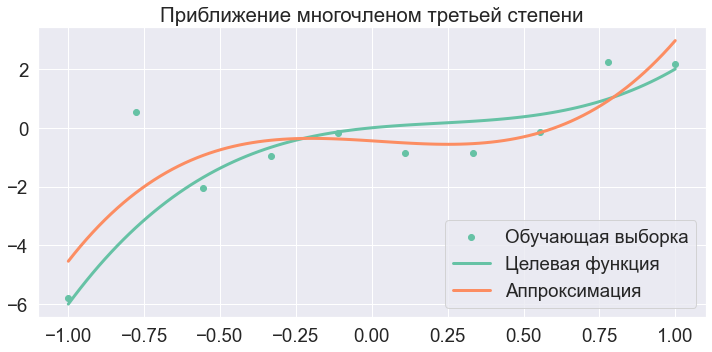

In [12]:
coefs = np.polyfit(x, y, deg=3) # подберем коэффициенты многочлена
poly = np.poly1d(coefs) # объявим функцию-многочлен с полученными коэффициентами

# визуализируем приближение
plot_poly(x, y, grid, f, poly, "Приближение многочленом третьей степени")

Несмотря на то, что предсказание получилось совсем не идеальным, модель получила гораздо более точное приближение. 

Это говорит о том, что важно строить модель, которая соответствует по сложности имеющимся данным. Для достижения этой цели существуют различные методы регуляризации, которые мы обсудим далее.

## 2. Напоминание

Для начала вспомним, что означают слова Ridge, Lasso и Elastic. Из курса статистики вы знаете, что такое линейная регрессия. 
* **Ridge** &mdash; это модель линейной регрессии, которая минимизирует $\lVert y - X \theta\rVert^2_2 + \alpha \cdot \lVert\theta\rVert^2_2$, где $y$ &mdash; истинные значения целевой переменной, $X$ &mdash; матрица "объект-признак", $\theta$ &mdash; параметры модели, $\alpha$ &mdash; параметр регуляризации.  
* **Lasso**-регрессия минимизирует $\lVert y - X \theta\rVert^2_2 + \alpha \cdot \lVert\theta\rVert_1$   
* **Elastic**-регрессия минимизирует $\lVert y - X\theta\rVert^2_2 + \alpha_1 \cdot \lVert\theta\rVert_1 + \alpha_2 \cdot \lVert\theta\rVert^2_2$. Таким образом Elastic-регрессия является компромиссом между $l_1$ и $l_2$ регуляризацией, позже мы в этом убедимся. 

Остановимся подробнее на каждой из моделей в контексте их использования с помощью библиотеки sklearn.

Рассмотрим работу линейных моделей на данных о диабете. Мы будем восстанавливать зависимость количественного показателя прогрессирования заболевания от давления, массы, пола, возраста и шести показателей сыворотки крови.

## 3. Данные

Считываем данные:

In [13]:
X = load_diabetes()['data']
y = load_diabetes()['target']
columns_name = load_diabetes()['feature_names'] + ['target']

data = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))), columns=columns_name)

Описание датасета:

In [14]:
print(load_diabetes()['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [15]:
data.describe().round(4)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000
mean,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,152.1335
std,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,77.0930
min,-0.1072,-0.0446,-0.0903,-0.1124,-0.1268,-0.1156,-0.1023,-0.0764,-0.1261,-0.1378,25.0000
25%,-0.0373,-0.0446,-0.0342,-0.0367,-0.0342,-0.0304,-0.0351,-0.0395,-0.0332,-0.0332,87.0000
50%,0.0054,-0.0446,-0.0073,-0.0057,-0.0043,-0.0038,-0.0066,-0.0026,-0.0019,-0.0011,140.5000
75%,0.0381,0.0507,0.0312,0.0356,0.0284,0.0298,0.0293,0.0343,0.0324,0.0279,211.5000
max,0.1107,0.0507,0.1706,0.1320,0.1539,0.1988,0.1812,0.1852,0.1336,0.1356,346.0000


Как видим, данные уже центрированы.

Разделим их на тренировочную и валидационную части:

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Ridge-регрессия

Используем Ridge-регрессию:

In [17]:
model = Ridge(
    # коэффициент регуляризации, чем больше - тем сильнее регуляризация
    alpha=1.0,
    # использовать ли параметр-остаток при обучении 
    fit_intercept=True,
    # максимальное количество итераций в методе оптимизации
    # при использовании итеративного метода
    max_iter=100,
    # точность решения, 
    # чем значение меньше, тем больше может потребоваться итераций
    tol=0.0001,
    # используемый метод оптимизации
    solver='auto'
)

Рассмотрим подробнее параметр `solver`.

 Доступные параметры:

* `auto` выбирает автоматически под тип даннных.
  

* `svd` использует сингулярное разложение матрицы для вычисления коэффициентов регрессии. Более стабильный метод для вырожденных матриц, чем метод `cholesky`.
  

* [`cholesky`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html) использует функцию из `scipy.linalg.solve`. 
  

* [`sparse_cg`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.cg.html) использует функцию из `scipy.sparse.linalg.cg`.
  

* [`lsqr`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.lsqr.html) использует функцию из `scipy.sparse.linalg.lsqr`.
  

* `sag` и `saga` - стохастический градиентный спуск. Метод `saga` заявлен как улучшенная версия метода `sag`. Данные методы являются итеративными и лучше сходятся, когда признаки находятся в одном масштабе (то есть для данных нужно выполнять некоторый препроцессинг, например, при помощи `StandartScaler` из `sklearn`).

Обучаем модель.

In [18]:
model.fit(X_train, y_train)

Ridge(max_iter=100, tol=0.0001)

Посмотрим на различные параметры модели.

Коэффициенты модели.

In [19]:
model.coef_

array([  45.36685974,  -76.66636624,  291.33821592,  198.99801883,
         -0.53043412,  -28.57734739, -144.51218613,  119.25996024,
        230.22123209,  112.14980968])

Свободный параметр.

In [20]:
model.intercept_

152.24169079372942

Число итераций, вернет None если solver не итеративный.

In [21]:
model.n_iter_ 

Настройки модели, которые использовались при обучении.

In [22]:
model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 100,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

Теперь займемся визуализацией. Посмотрим, как ведут себя предсказания в зависимости от изменения параметров модели.

In [23]:
def linear_predictor(alpha, model, count_of_objects=20):
    """Данная функция строит график предсказаний модели 
    на первых count_of_objects объектах валидационной выборки.
    
    :param alpha: коэффициент регуляризации
    :param model: тип модели
    """

    if model == 'Ridge':
        model = Ridge(alpha=alpha, max_iter=1000, fit_intercept=True)
    elif model == 'Lasso':
        model = Lasso(alpha=alpha, max_iter=1000, fit_intercept=True)
    elif model == 'Elastic':
        model = ElasticNet(alpha=alpha, max_iter=1000, fit_intercept=True)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    plt.figure(figsize=(14, 5))

    plt.scatter(np.arange(count_of_objects), y_pred[:count_of_objects], 
              color='#0066FF', label='Предсказания модели')
    plt.plot(np.arange(count_of_objects), y_pred[:count_of_objects], 
          color='#0066FF')
    plt.scatter(np.arange(count_of_objects), y_val[:count_of_objects], 
                color='#FF3300', label='Истинные значения')

    plt.grid(ls=':')
    plt.xlabel('Номер объекта', fontsize=19)
    plt.xticks(np.arange(count_of_objects))
    plt.ylabel('Предсказание', fontsize=19)
    plt.title('Предсказания на {} объектах валидационной выборки'.format(count_of_objects), 
              fontsize=22)
    plt.legend(fontsize=19)
    plt.show() 

In [24]:
# создать виджет, но не отображать его
ip = widgets.interactive(
    linear_predictor, 
    alpha=widgets.FloatSlider(min=0.0001, max=10, step=0.01, value=1),
    model='Ridge'
);

# отображаем слайдер
display(widgets.HBox(ip.children[:1]))

# отображаем вывод функции
display(ip.children[-1])
ip.update() # чтобы функция запустилась до первого изменения слайдеров

Output()

## 5. Lasso-регрессия

In [25]:
model = Lasso(
    # коэффициент регуляризации, чем больше - тем сильнее регуляризация
    alpha=1.0,
    # использовать ли параметр-остаток при обучении
    fit_intercept=True,
    # максимальное количество итераций в методе оптимизации
    max_iter=100,
    # точность решения, 
    # чем значение меньше, тем больше может потребоваться итераций
    tol=0.0001,
    # использовать ли предпосчитанную матрицу Грама для ускорения расчетов
    precompute=True,
    # использовать ли результаты последнего обучения для инициализации
    warm_start=False,
    # если True, то будет подбирать положительные коэффициенты
    positive=False  
)

Для оптимизации используется покоординатный градиентный спуск.

Обучаем модель

In [26]:
model.fit(X_train, y_train)

Lasso(max_iter=100, precompute=True)

Посмотрим на различные параметры модели.

Коэффициенты модели.

In [27]:
model.coef_

array([  0.        ,  -0.        , 413.4304682 ,  34.83548263,
         0.        ,   0.        ,  -0.        ,   0.        ,
       258.15143648,   0.        ])

Свободный параметр.

In [28]:
model.intercept_

152.66397265031173

Разряженное представление коэффициентов, хранятся только ненулевые элементы.

In [29]:
model.sparse_coef_ 

<1x10 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [30]:
print(model.sparse_coef_)

  (0, 2)	413.4304682004709
  (0, 3)	34.83548263021875
  (0, 8)	258.15143648109176


Количество итераций.

In [31]:
model.n_iter_ 

8

Визуализация.

In [32]:
# создать виджет, но не отображать его
ip = widgets.interactive(
    linear_predictor, 
    alpha=widgets.FloatSlider(min=0.0001, max=10, step=0.01, value=1),
    model="Lasso"
);

# отображаем слайдер
display(widgets.HBox(ip.children[:1]))

# отображаем вывод функции
display(ip.children[-1])
ip.update() # чтобы функция запустилась до первого изменения слайдеров

Output()

# 6. Elastic-регрессия

In [33]:
model = ElasticNet(
    # коэффициент регуляризации, чем больше - тем сильнее регуляризация
    alpha=0.01, 
    # какое предпочтение отдавать l1, а не l2
    l1_ratio=0.6, 
    # использовать ли параметр-остаток при обучении
    fit_intercept=True,    
    # максимальное количество итераций в методе оптимизации
    max_iter=100,
    # точность решения, 
    # чем значение меньше, тем больше может потребоваться итераций
    tol=0.0001, 
    # использовать ли предпосчитанную матрицу Грама для ускорения расчетов
    precompute=True,  
    # использовать ли результаты последнего обучения для инициализации
    warm_start=False, 
    # если True, то будет подбирать положительные коэффициенты
    positive=False  
)

Для оптимизации используется покоординатный градиентный спуск.

Разберемся чуть подробнее в связи между `alpha`, `l1_ratio` с $\alpha_1, \alpha_2$, которые мы вводили:

$$
\verb|alpha| = \alpha_1 + 2\alpha_2
\\
\verb|l1_ratio| = \frac{\alpha_1}{\alpha_1 + 2\alpha_2}
\\
\alpha_1 = \verb|alpha| \cdot \verb|l1_ratio|
\\
\alpha_2 = \frac{1}{2} \verb|alpha| \cdot (1 - \verb|l1_ratio|)
$$

 Обучаем модель.

In [34]:
model.fit(X_train, y_train)

ElasticNet(alpha=0.01, l1_ratio=0.6, max_iter=100, precompute=True)

Посмотрим на различные параметры модели.

Коэффициенты модели.

In [35]:
model.coef_

array([  42.90138132,  -54.67566469,  247.22133754,  171.46610017,
          8.48103576,  -12.57663066, -126.88363189,  109.73080011,
        199.14535875,  105.64994062])

Свободный параметр.

In [36]:
model.intercept_

152.43924910395097

Разряженное представление коэффициентов, хранятся только ненулевые элементы.

In [37]:
model.sparse_coef_ 

<1x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [38]:
print(model.sparse_coef_)

  (0, 0)	42.90138132006671
  (0, 1)	-54.67566469073401
  (0, 2)	247.2213375376006
  (0, 3)	171.4661001707383
  (0, 4)	8.481035763445542
  (0, 5)	-12.576630660330588
  (0, 6)	-126.88363189186398
  (0, 7)	109.73080010797787
  (0, 8)	199.14535875155596
  (0, 9)	105.64994061690885


Количество итераций.

In [39]:
model.n_iter_ 

8

Визуализация.

In [40]:
# создать виджет, но не отображать его
ip = widgets.interactive(
    linear_predictor, 
    alpha=widgets.FloatSlider(min=0.0001, max=0.1, step=0.001, value=0.01),
    model="Elastic"
);

# отображаем слайдер
display(widgets.HBox(ip.children[:1]))

# отображаем вывод функции
display(ip.children[-1])
ip.update() # чтобы функция запустилась до первого изменения слайдеров

Output()

## 7. Сравнение моделей

Рассмотрим графики зависимости значений параметров моделей от параметра регуляризации.

In [41]:
def draw_track(model, X, y, log_min, log_max, num, title='', figsize=(12, 6)):
    """Данная функция строит график зависимости значений 
    коэффициентов модели от параметра регуляризации.
    
    :param model: модель
    :param X: регрессоры
    :param y: отклик
    :param log_min: десятичный логарифм 
        минимального значения коэффициента регуляризации
    :param log_max: десятичный логарифм 
        максимального значения коэффициента регуляризации
    :param num: количество элементов в сетке для коэффициента регуляризации
    :param title: заголовок графика
    :param figsize: размер полотна
    """
    
    alphas = np.logspace(log_min, log_max, num)   
    coefs = []
    for a in alphas:
        if 'l1_ratio' in model.get_params():
            # равномерно распределим alpha по обоим коэффициентам
            a *= 3/2
            model.set_params(alpha=a)
        else:
            model.set_params(alpha=a)
        model.fit(X, y)
        coefs.append(model.coef_)

    plt.figure(figsize=figsize)
    ax = plt.gca()
#     ax.hlines(0, 10 ** log_min, 10 ** log_max, linewidth=15, alpha=0.15)
    ind = 1
    for coef in np.array(coefs).T:
        label = r'$\theta_{' + str(ind) + '}$'
        ax.plot(alphas, coef, linewidth=2, label=label)
        ind += 1
        
    ax.set_xscale('log')
#     ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha', fontsize=19)
    plt.ylabel('weights', fontsize=19)
    plt.title(title, fontsize=22)
    plt.legend(loc='upper left', fontsize=15)
    plt.axis('tight')
    plt.show()

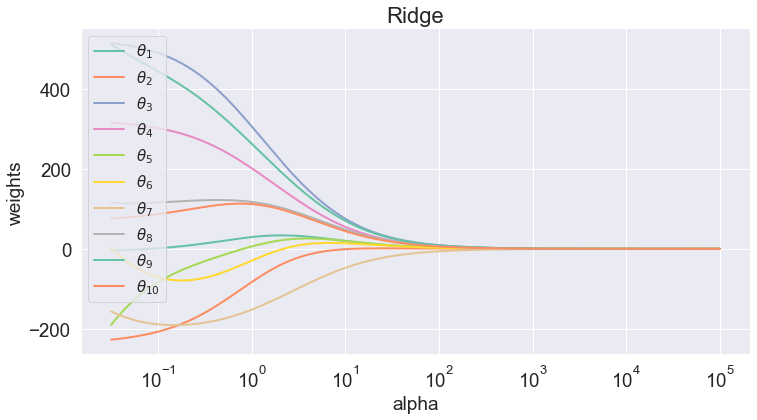

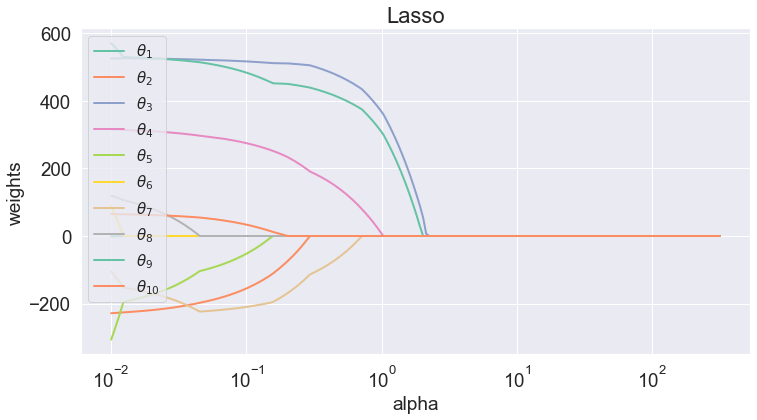

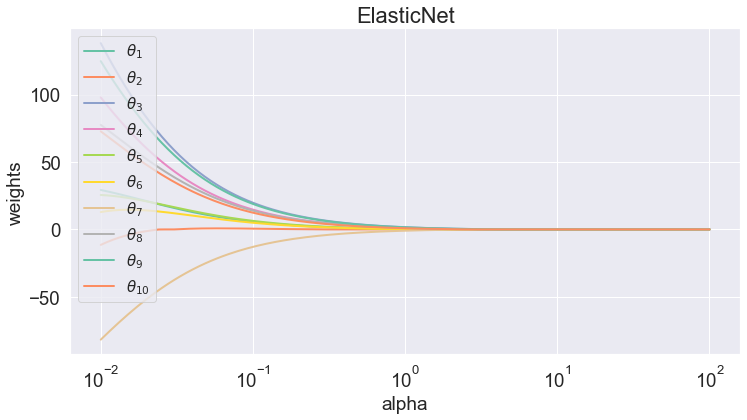

In [42]:
draw_track(Ridge(fit_intercept=False), X, y, -1.5, 5, 200, 
           title='Ridge')
draw_track(Lasso(fit_intercept=False), X, y, -2, 2.5, 200, 
           title='Lasso')
draw_track(ElasticNet(fit_intercept=False, l1_ratio=1/3), X, y, -2, 2, 200, 
           title='ElasticNet')

Из графиков выше можно сделать вывод, что при высоких значениях коэффициента регуляризации модели не учатся и все коээфициенты зануляются.  Также важно заметить, что Lasso при высоких значениях коэффициента регуляризации склонна занулять параметры, но в отличие от других моделей она **отбирает** определенные признаки начиная с некоторого значения коэффициента регуляризации. Другими словами, с ослаблением регуляризации Lasso присваивает ненулевые значения лишь каким-то конкретным признакам, которые считает наиболее важными. 